# Import Packages and Classifiers

In [15]:
#!pip install --user scikit-learn

In [16]:
#!pip install --user matplotlib

In [17]:
#!pip install --user pandas

In [18]:
#!pip install --user numpy

In [19]:
#!pip install --user seaborn

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import accuracy_score
import time

from sklearn.model_selection import learning_curve
import pandas as pd 
import numpy as np  


https://scikit-learn.org/stable/modules/cross_validation.html

# Import Data 

In [21]:
hr_data = pd.read_csv("hr_data.csv")
bank_data = pd.read_csv("bank-marketing.csv")

# First Dataset 
https://www.kaggle.com/dhirajnirne/bank-marketing

## Prep Data for Modeling 

In [22]:
bank_data.columns

Index(['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'response'],
      dtype='object')

In [23]:
categorical_cols = ['age group', 'eligible', 'job', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'poutcome']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(bank_data[i].unique())
    bank_data[i] = le.transform(bank_data[i])

In [73]:
target = 'response'
cols = ['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

#splitn into training and testing data sets
train, test = train_test_split(bank_data, test_size=0.3, random_state = 30)

In [74]:
train_sizes = np.arange(1, len(train), 1500).tolist()#.append(len(train))
train_sizes.append(len(train)-1)


## Decision Tree with Pruning 
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/

In [26]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities


In [84]:
from sklearn.metrics import accuracy_score
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = accuracy_score(test[target], y_test_pred) if max_score < accuracy_score(test[target], y_test_pred) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

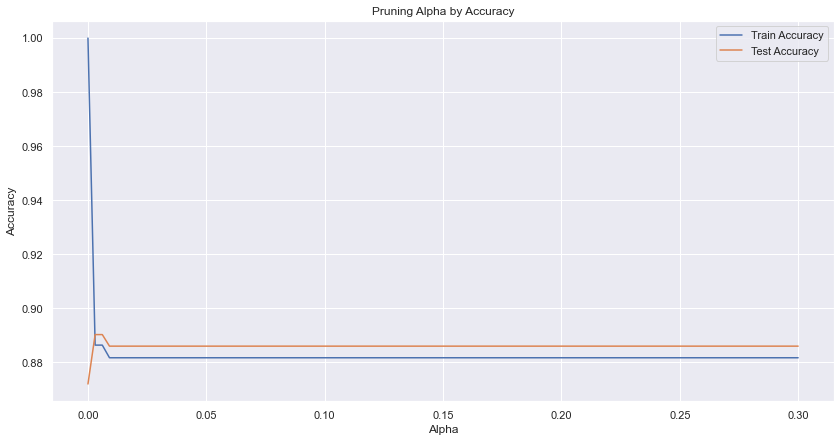

In [89]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [98]:
start_time = time.time()
no_prune_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0)
no_prune_tree.fit(train[cols], train[target])
no_prune_tree_runtime = time.time() - start_time
no_prune_tree_training_error = 1 - accuracy_score(train[target], no_prune_tree.predict(train[cols]))
no_prune_tree_error = 1 - accuracy_score(test[target], no_prune_tree.predict(test[cols]))

In [102]:
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

In [99]:
max_score_alpha

0.0030303030303030303

In [100]:
no_prune_tree.tree_.node_count

5115

In [101]:
no_prune_tree.tree_.max_depth 

30

In [103]:
final_tree.tree_.node_count

9

In [104]:
final_tree.tree_.max_depth 

4

In [30]:
final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, final_tree_runtime] ).T

In [106]:
bad_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=.1)
bad_tree.fit(train[cols], train[target])
print(bad_tree.tree_.node_count)
print(bad_tree.tree_.max_depth )

1
0


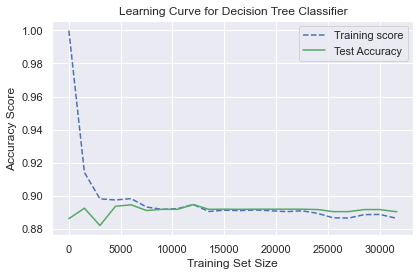

In [107]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Decision Tree Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Neural Network
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [127]:
start_time = time.time()
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter = 200000)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, nn_runtime] ).T

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [110]:
start_time = time.time()
nn = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, nn_runtime] ).T

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(


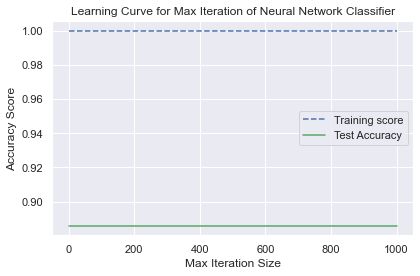

In [129]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100 , dtype = int)
for i in max_iter:
    classifier  = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter = i)
    classifier.fit(train[cols], train[target].apply(lambda x: int()))
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration of Neural Network Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


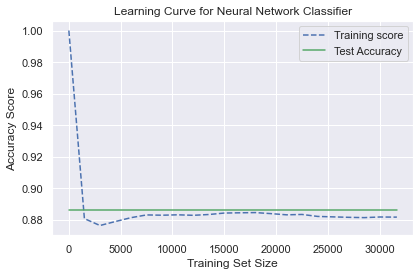

In [130]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Neural Network Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Boosting 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.

In [131]:
alphas = np.linspace(0,.3, num = 100)
accuracy_train, accuracy_test = [], []

for i in alphas:
    
    tree = GradientBoostingClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])

    accuracy_train.append(tree.score(train[cols], train[target]))
    accuracy_test.append(tree.score(test[cols], test[target]))
    
     #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = accuracy_score(test[target], y_test_pred) if max_score < accuracy_score(test[target], y_test_pred) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

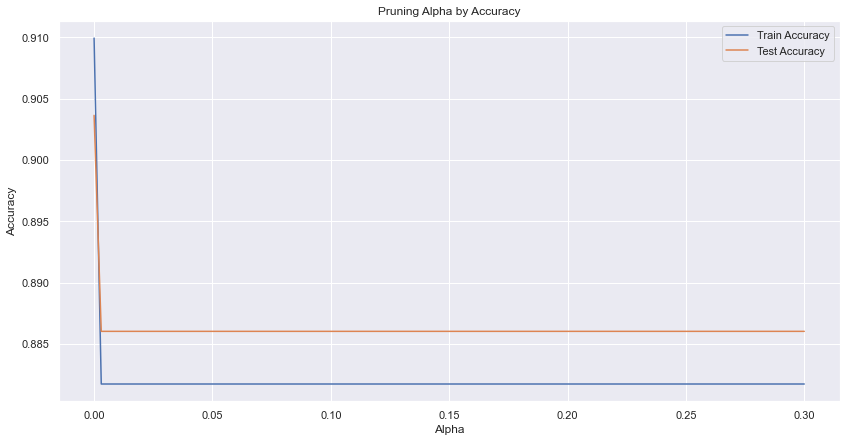

In [132]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [133]:
max_score_alpha

0.0030303030303030303

In [134]:
start_time = time.time()
gbc = GradientBoostingClassifier(random_state=0, ccp_alpha=max_score_alpha)
gbc.fit(train[cols], train[target])
gbc_runtime = time.time() - start_time
gbc_training_error = 1 - accuracy_score(train[target], gbc.predict(train[cols]))
gbc_error = 1 - accuracy_score(test[target], gbc.predict(test[cols]))

gbc_row = pd.DataFrame(['Gradient Boosting Tree', gbc_training_error, gbc_error, gbc_runtime] ).T

In [136]:
gbc.max_depth

3

In [173]:
min_depth = 0
max_depth = 0
for i in range(100):
    
    max_depth = gbc.estimators_[i, 0].tree_.node_count if max_depth < gbc.estimators_[i, 0].tree_.node_count else max_depth
    min_depth = gbc.estimators_[i, 0].tree_.node_count if min_depth > gbc.estimators_[i, 0].tree_.node_count else min_depth  
               
    #print(gbc.estimators_[i, 0].tree_.node_count)          
               

In [174]:
print(max_depth)
print(min_depth)

7
0


## Support Vector Machines 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py

In [38]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, clf_runtime] ).T

### Linear 

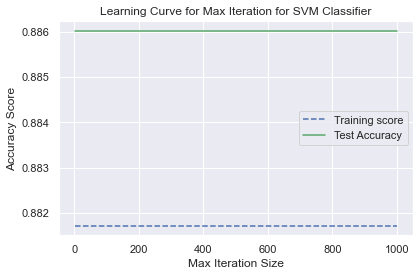

In [40]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel= 'linear'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'linear' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Poly

In [175]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'poly' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

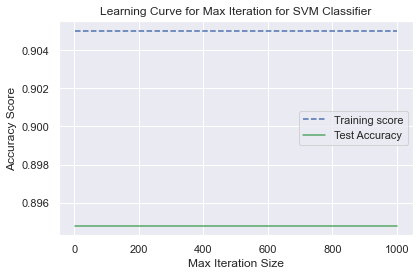

In [42]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## K Nearest Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


Text(0.5, 1.0, 'Test Accuracy by Number of Neighbors')

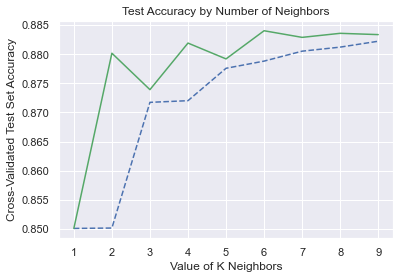

In [43]:
from sklearn.model_selection import GridSearchCV
#https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
k_range = list(range(1, 10))

# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = [{'n_neighbors': k_range,
         'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(train[cols], train[target])

# plot the results
# this is identical to the one we generated above

distance_results = grid.cv_results_.get('mean_test_score')[1::2]
uniform_results = grid.cv_results_.get('mean_test_score')[::2]


plt.plot(k_range, distance_results, '--', color="b",  label="Distance Neighbor Weight")
plt.plot(k_range, uniform_results, color="g", label="Uniform Neighbor Weight")
plt.xlabel('Value of K Neighbors')
plt.ylabel('Cross-Validated Test Set Accuracy')
plt.title('Test Accuracy by Number of Neighbors')

In [44]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'), weights = grid.best_params_.get('weights'))
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, neigh_runtime]).T 

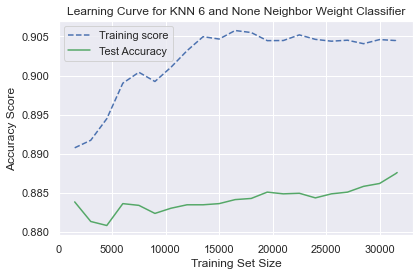

In [45]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1:
        train_data_subset = train.head(i)
        classifier  = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

num_of_neighbors = grid.best_params_.get('n_neighbors')
neighbor_weight = grid.best_params_.get('weight')
plt.title(f"Learning Curve for KNN {num_of_neighbors} and {neighbor_weight} Neighbor Weight Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [46]:
final_df = neigh_row.append(clf_row).append(gbc_row).append(nn_row).append(final_tree_row)
final_df.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Training Time']
final_df

,Classifier Name,Training Error,Testing Error,Training Time
0,K Nearest Neighbor,0.095712,0.112504,0.005743
0,Support Vector Machine,0.090625,0.101298,13.896581
0,Gradient Boosting Tree,0.118273,0.113978,3.387156
0,Neural Network,0.118273,0.113978,0.120663
0,Decision Tree,0.118273,0.113978,0.168609


# Second Dataset   

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv

## Prep Data for Modeling 

In [47]:
hr_data.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [48]:
categorical_cols = ['city', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(hr_data[i].unique())
    hr_data[i] = le.transform(hr_data[i])



In [49]:
target = 'target'
cols = ['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']

#splitn into training and testing data sets
train, test = train_test_split(hr_data, test_size=0.3, random_state = 30)
train_sizes = np.arange(1, len(train), 1000).tolist()
train_sizes.append(len(train)-1)

## Decision Tree with Pruning 

In [50]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = max_score if max_score < accuracy_score(test[target], y_test_pred) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

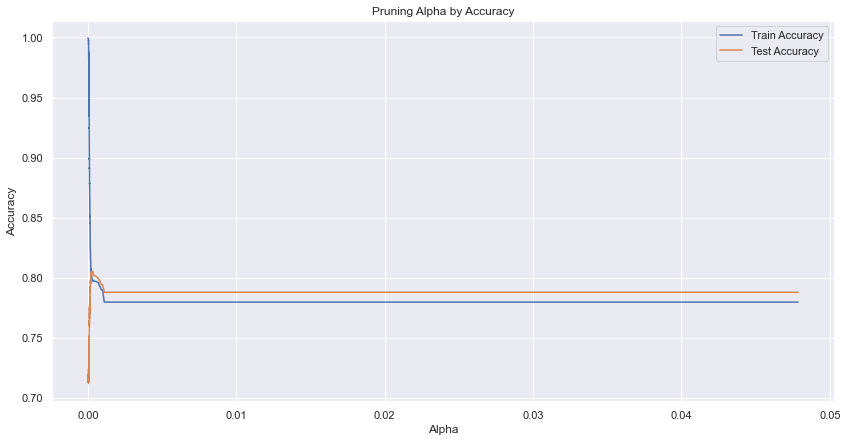

In [51]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [52]:
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, final_tree_runtime] ).T

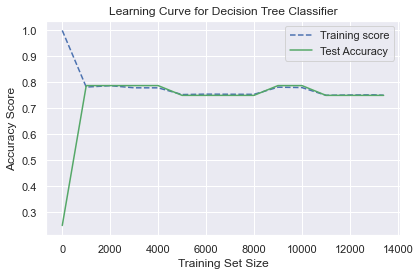

In [53]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Decision Tree Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Neural Network

In [54]:
start_time = time.time()
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, nn_runtime] ).T

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

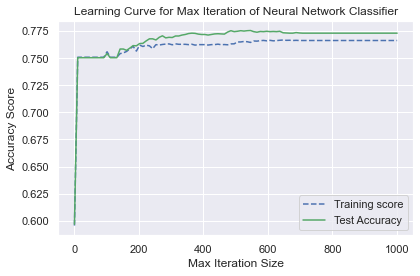

In [55]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter = i)
    classifier.fit(train[cols], train[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration of Neural Network Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

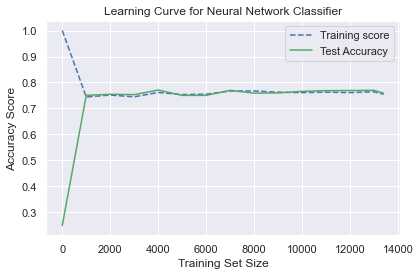

In [56]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")


plt.title("Learning Curve for Neural Network Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Boosting 

In [57]:
alphas = np.linspace(0,.3, num = 100)
accuracy_train, accuracy_test = [], []

In [58]:
for i in alphas:
    
    tree = GradientBoostingClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])

    accuracy_train.append(tree.score(train[cols], train[target]))
    accuracy_test.append(tree.score(test[cols], test[target]))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < tree.score(train[cols], train[target]) else max_score_alpha  
    max_score = max_score if max_score < tree.score(test[cols], test[target]) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

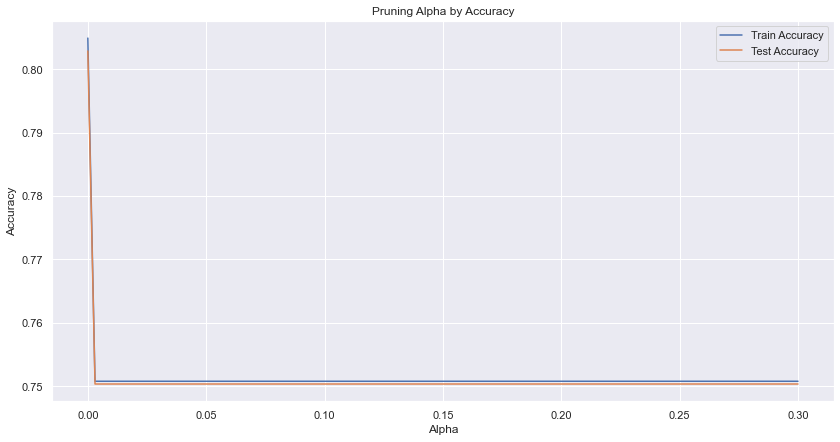

In [59]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [60]:
start_time = time.time()
gbc = GradientBoostingClassifier(random_state=0, ccp_alpha=max_score_alpha)
gbc.fit(train[cols], train[target])
gbc_runtime = time.time() - start_time
gbc_training_error = 1 - accuracy_score(train[target], gbc.predict(train[cols]))
gbc_error = 1 - accuracy_score(test[target], gbc.predict(test[cols]))

gbc_row = pd.DataFrame(['Gradient Boosting Tree', gbc_training_error, gbc_error, gbc_runtime] ).T

## Support Vector Machines 

In [61]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, clf_runtime] ).T

### Linear Kernel

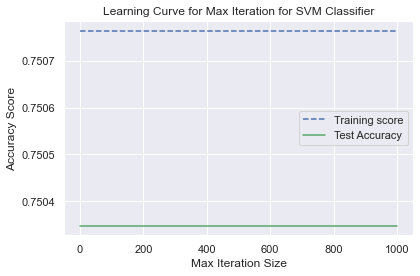

In [62]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

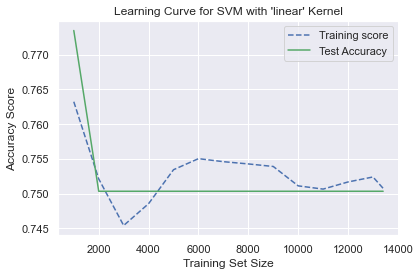

In [63]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'linear' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Poly Kernel

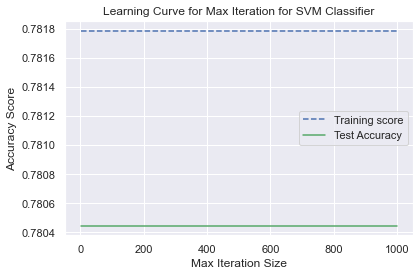

In [65]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

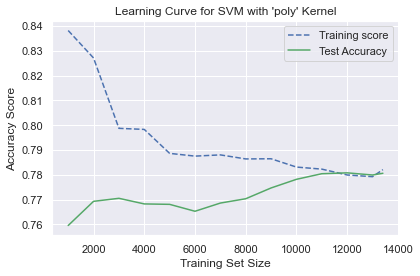

In [66]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'poly' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## K Nearest Neighbors

Text(0.5, 1.0, 'Test Accuracy by Number of Neighbors')

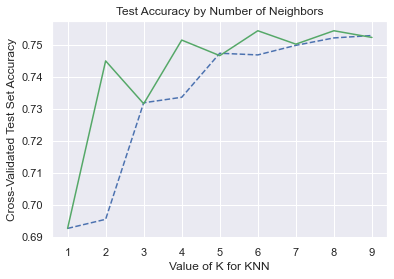

In [67]:
from sklearn.model_selection import GridSearchCV
#https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
k_range = list(range(1, 10))

# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = [{'n_neighbors': k_range,
         'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(train[cols], train[target])

# plot the results
distance_results = grid.cv_results_.get('mean_test_score')[1::2]
uniform_results = grid.cv_results_.get('mean_test_score')[::2]

plt.plot(k_range, distance_results, '--', color="b",  label="Distance Neighbor Weight")
plt.plot(k_range, uniform_results, color="g", label="Uniform Neighbor Weight")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Test Set Accuracy')
plt.title('Test Accuracy by Number of Neighbors')

In [68]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, neigh_runtime]).T 

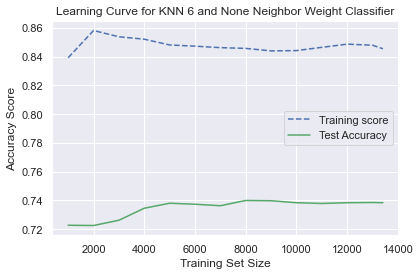

In [69]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = KNeighborsClassifier(n_neighbors=3)
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

num_of_neighbors = grid.best_params_.get('n_neighbors')
neighbor_weight = grid.best_params_.get('weight')
plt.title(f"Learning Curve for KNN {num_of_neighbors} and {neighbor_weight} Neighbor Weight Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [70]:
final_df = neigh_row.append(clf_row).append(gbc_row).append(nn_row).append(final_tree_row)
final_df.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Training Time']

In [71]:
final_df

,Classifier Name,Training Error,Testing Error,Training Time
0,K Nearest Neighbor,0.196495,0.242171,0.012502
0,Support Vector Machine,0.199702,0.208246,4.919909
0,Gradient Boosting Tree,0.249217,0.249652,0.732301
0,Neural Network,0.239224,0.238518,0.589477
0,Decision Tree,0.249217,0.249652,0.062735
